# Yarrowia Lipolytica Media Optimisation Pretest
## This code is to generate output for the report on the media optimisation pretest for Yarrowia conducted to assess the suitability of 24 vs 96 well-plates, and human vs machine pipetting, by using the growth profiler with 4 different mediums derived from the Yarorwia media matrix. 

### The objective of this code is to pull in an excel file of all OD measurements and green value measurements across the 4 conditions, assess the signifcance of difference between media compositions, and generate summary statistics.

In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import AnovaRM

In [9]:
pathxlsx = "data/Growth Profiler Results 96v24 pretest.xlsx"

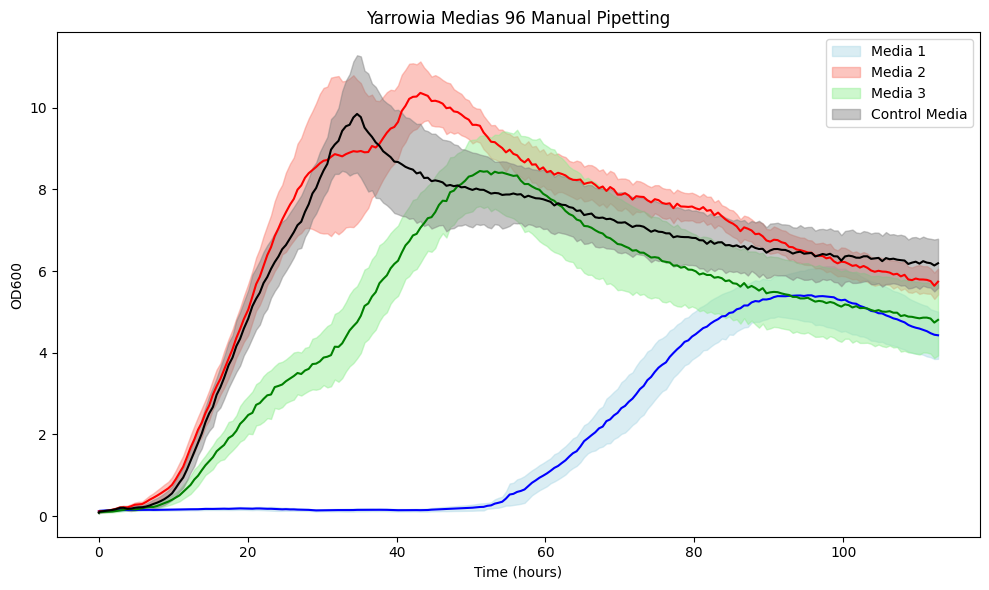

ANOVA results across entire time series:
F-statistic: 158.8973
p-value: 1.2095e-82
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Media_1 Media_2   4.6241    0.0  4.0237  5.2244   True
Media_1 Media_3   2.9302    0.0  2.3298  3.5306   True
Media_1 Media_4   4.1603    0.0  3.5599  4.7607   True
Media_2 Media_3  -1.6939    0.0 -2.2942 -1.0935   True
Media_2 Media_4  -0.4638 0.1932 -1.0641  0.1366  False
Media_3 Media_4   1.2301    0.0  0.6298  1.8305   True
------------------------------------------------------
           Mixed Linear Model Regression Results
Model:              MixedLM Dependent Variable: OD600      
No. Observations:   8136    Method:             REML       
No. Groups:         36      Scale:              4.4075     
Min. group size:    226     Log-Likelihood:     -17634.7586
Max. group size:    226     Converged:          Yes        
Mean group size:  

c:\Users\uqkmuroi\gitcode\Yarrowia_media_optimizer\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\uqkmuroi\gitcode\Yarrowia_media_optimizer\venv\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(


In [65]:
df = pd.read_excel(pathxlsx, sheet_name='OD96_Manual', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6', 'B4', 'B5', 'B6', 'C4', 'C5', 'C6']].mean(axis=1)
df['Media_3_Avg'] = df[['A7', 'A8', 'A9', 'B7', 'B8', 'B9', 'C7', 'C8', 'C9']].mean(axis=1)
df['Media_4_Avg'] = df[['A10', 'A11', 'A12', 'B10', 'B11', 'B12', 'C10', 'C11', 'C12']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6', 'B4', 'B5', 'B6', 'C4', 'C5', 'C6']].std(axis=1)
df['Media_3_Std'] = df[['A7', 'A8', 'A9', 'B7', 'B8', 'B9', 'C7', 'C8', 'C9']].std(axis=1)
df['Media_4_Std'] = df[['A10', 'A11', 'A12', 'B10', 'B11', 'B12', 'C10', 'C11', 'C12']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 96 Manual Pipetting')
ax.legend()

plt.tight_layout()
plt.show()


# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")



# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())



import statsmodels.formula.api as smf


# Fit a simpler mixed-effects model: OD600 ~ Time + Media
model = smf.mixedlm("OD600 ~ Time + Media", long_df, groups=long_df["Subject"])
result = model.fit()

print(result.summary())






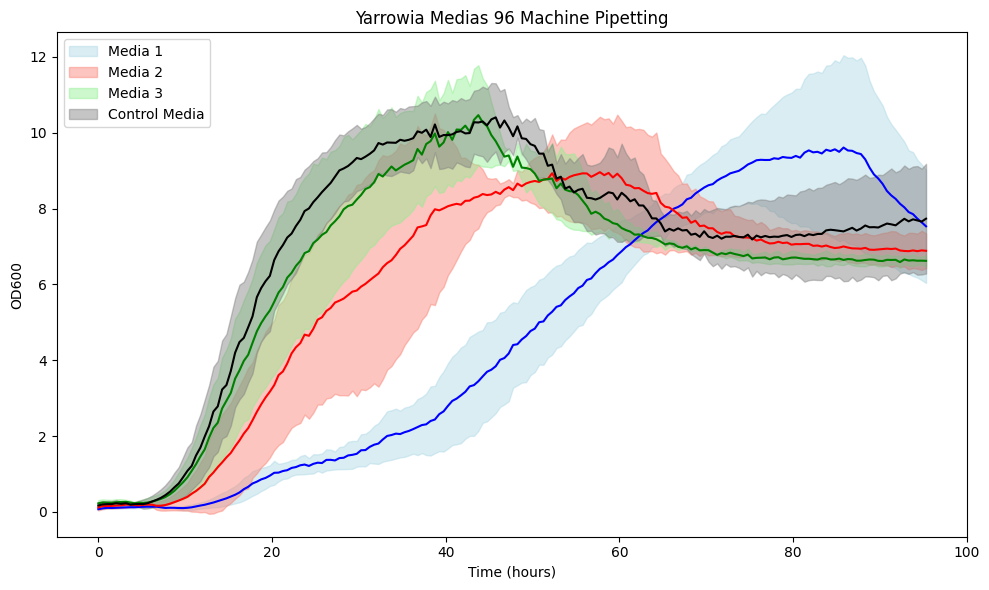

ANOVA results across entire time series:
F-statistic: 21.9528
p-value: 1.2164e-13
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Media_1 Media_2   1.3431 0.0001  0.5402 2.1461   True
Media_1 Media_3   1.8542    0.0  1.0512 2.6572   True
Media_1 Media_4   2.4165    0.0  1.6136 3.2195   True
Media_2 Media_3    0.511 0.3575 -0.2919  1.314  False
Media_2 Media_4   1.0734 0.0034  0.2704 1.8764   True
Media_3 Media_4   0.5624 0.2726 -0.2406 1.3653  False
-----------------------------------------------------


In [55]:
df = pd.read_excel(pathxlsx, sheet_name='OD96_Robot', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6']].mean(axis=1)
df['Media_3_Avg'] = df[['A7', 'A8', 'A9']].mean(axis=1)
df['Media_4_Avg'] = df[['A10', 'A11', 'A12']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6']].std(axis=1)
df['Media_3_Std'] = df[['A7', 'A8', 'A9']].std(axis=1)
df['Media_4_Std'] = df[['A10', 'A11', 'A12']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 96 Machine Pipetting')
ax.legend()

plt.tight_layout()
plt.show()


# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")


# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())


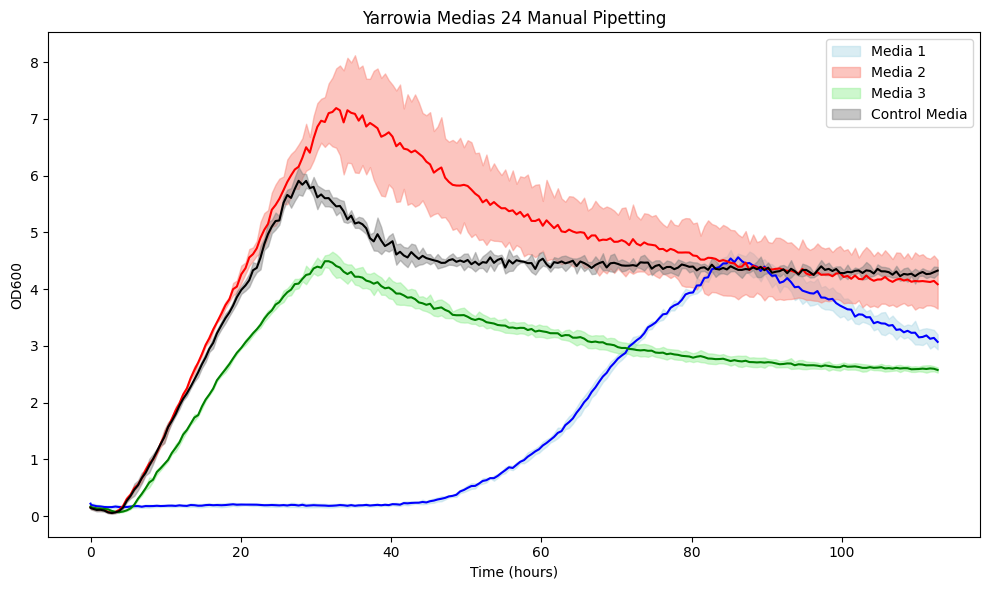

ANOVA results across entire time series:
F-statistic: 165.2819
p-value: 2.4426e-85
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Media_1 Media_2   2.7817    0.0  2.4286  3.1347   True
Media_1 Media_3   1.0846    0.0  0.7316  1.4376   True
Media_1 Media_4   2.2772    0.0  1.9242  2.6303   True
Media_2 Media_3  -1.6971    0.0 -2.0501  -1.344   True
Media_2 Media_4  -0.5044 0.0014 -0.8575 -0.1514   True
Media_3 Media_4   1.1926    0.0  0.8396  1.5457   True
------------------------------------------------------


In [66]:
df = pd.read_excel(pathxlsx, sheet_name='OD24_Manual', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6']].mean(axis=1)
df['Media_3_Avg'] = df[['B1', 'B2', 'B3']].mean(axis=1)
df['Media_4_Avg'] = df[['B4', 'B5', 'B6']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6']].std(axis=1)
df['Media_3_Std'] = df[['B1', 'B2', 'B3']].std(axis=1)
df['Media_4_Std'] = df[['B4', 'B5', 'B6']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 24 Manual Pipetting')
ax.legend()

plt.tight_layout()
plt.show()

# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")


# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())


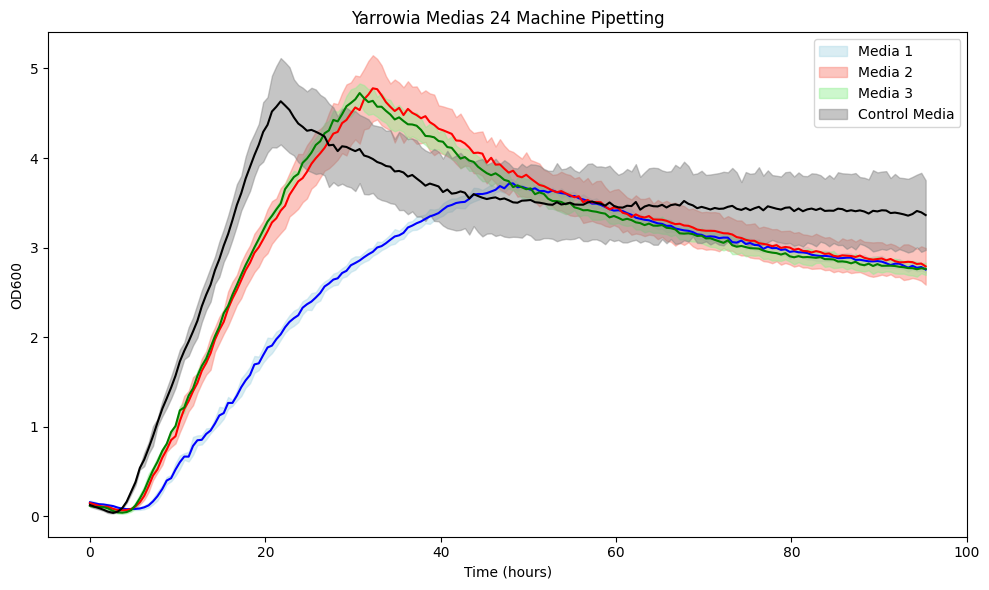

ANOVA results across entire time series:
F-statistic: 11.7434
p-value: 1.5838e-07
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
 group1  group2 meandiff p-adj   lower  upper  reject
-----------------------------------------------------
Media_1 Media_2   0.4805 0.0002  0.1857 0.7752   True
Media_1 Media_3   0.4392 0.0008  0.1444 0.7339   True
Media_1 Media_4   0.6512    0.0  0.3564 0.9459   True
Media_2 Media_3  -0.0413 0.9839 -0.3361 0.2535  False
Media_2 Media_4   0.1707 0.4434 -0.1241 0.4655  False
Media_3 Media_4    0.212 0.2501 -0.0828 0.5068  False
-----------------------------------------------------


In [58]:
df = pd.read_excel(pathxlsx, sheet_name='OD24_Robot', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6']].mean(axis=1)
df['Media_3_Avg'] = df[['B1', 'B2', 'B3']].mean(axis=1)
df['Media_4_Avg'] = df[['B4', 'B5', 'B6']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6']].std(axis=1)
df['Media_3_Std'] = df[['B1', 'B2', 'B3']].std(axis=1)
df['Media_4_Std'] = df[['B4', 'B5', 'B6']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 24 Machine Pipetting')
ax.legend()

plt.tight_layout()
plt.show()

# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")



# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())


# Green values version of above

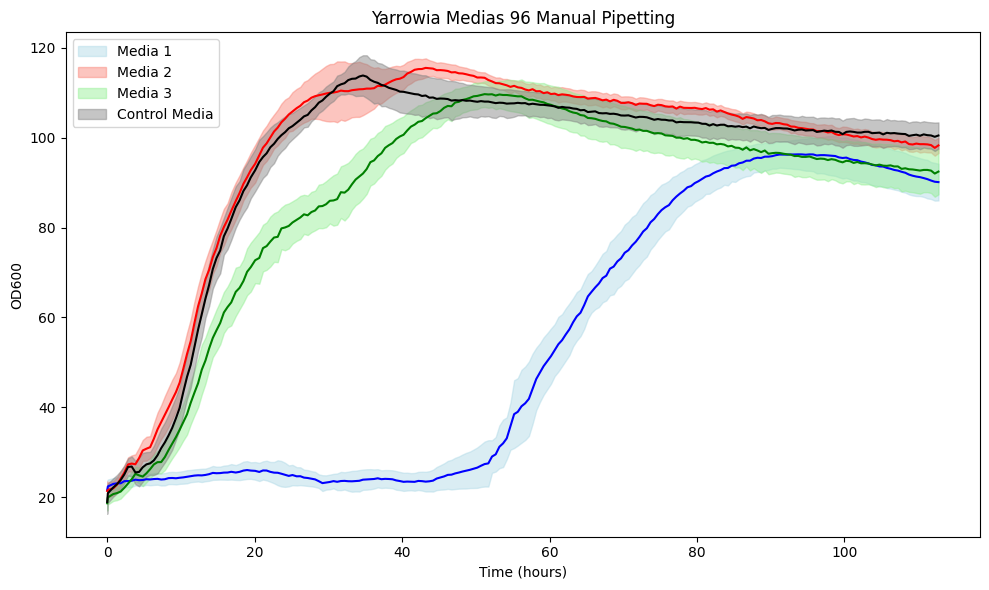

ANOVA results across entire time series:
F-statistic: 129.3274
p-value: 1.1740e-69
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
Media_1 Media_2  42.6411    0.0  36.3055 48.9768   True
Media_1 Media_3  33.0552    0.0  26.7196 39.3909   True
Media_1 Media_4  40.4858    0.0  34.1502 46.8215   True
Media_2 Media_3  -9.5859 0.0006 -15.9215 -3.2502   True
Media_2 Media_4  -2.1553 0.8175  -8.4909  4.1804  False
Media_3 Media_4   7.4306 0.0139   1.0949 13.7662   True
-------------------------------------------------------


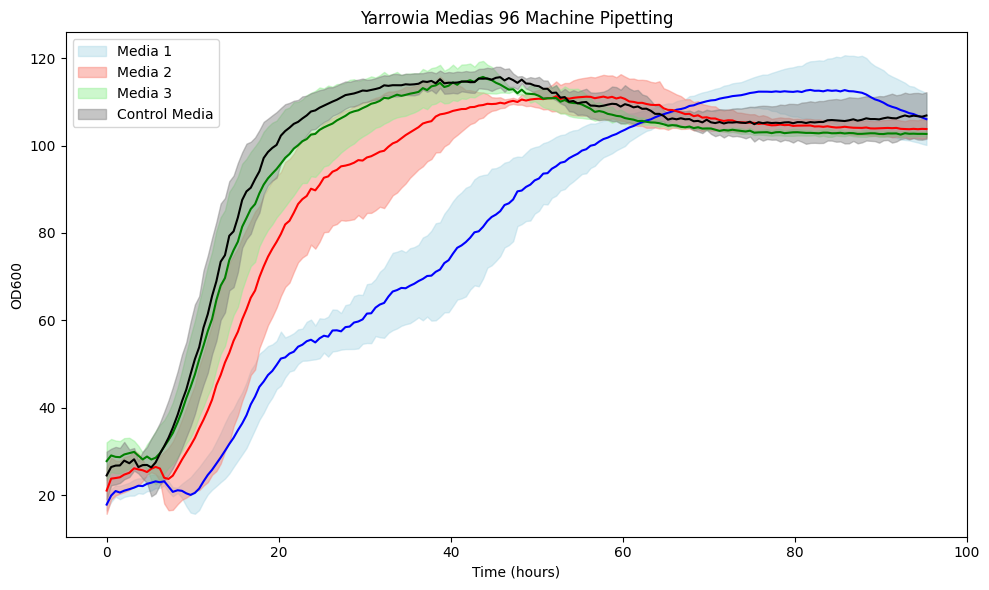

ANOVA results across entire time series:
F-statistic: 18.0532
p-value: 2.5210e-11
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Media_1 Media_2  12.3571 0.0001  5.0486 19.6655   True
Media_1 Media_3  16.7594    0.0   9.451 24.0679   True
Media_1 Media_4  19.1716    0.0 11.8631   26.48   True
Media_2 Media_3   4.4024 0.4076 -2.9061 11.7108  False
Media_2 Media_4   6.8145 0.0778 -0.4939  14.123  False
Media_3 Media_4   2.4121 0.8305 -4.8963  9.7206  False
------------------------------------------------------


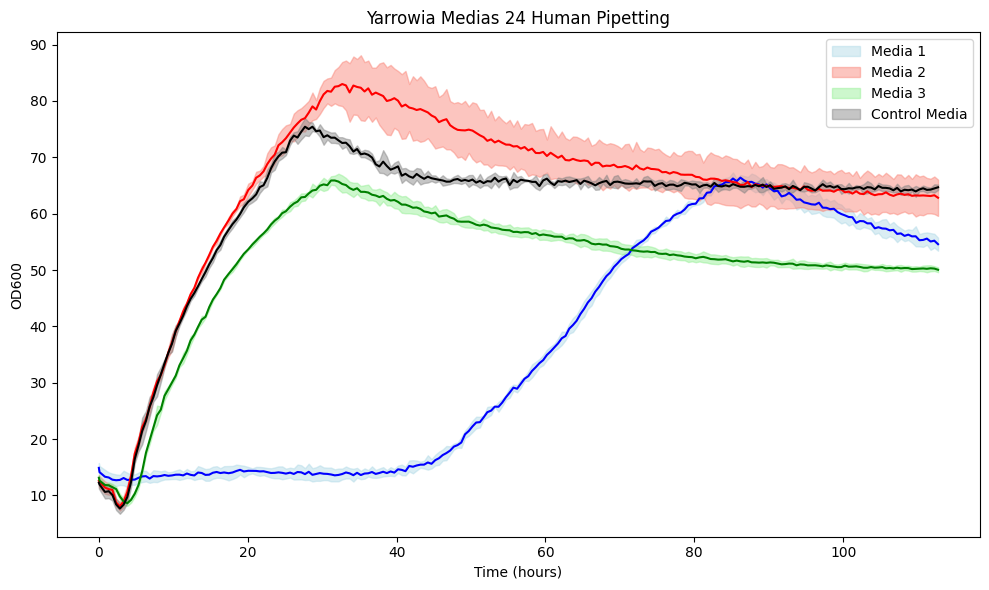

ANOVA results across entire time series:
F-statistic: 134.7540
p-value: 4.1794e-72
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower    upper  reject
-------------------------------------------------------
Media_1 Media_2  28.5474    0.0  24.5324 32.5625   True
Media_1 Media_3   15.448    0.0   11.433  19.463   True
Media_1 Media_4  25.2145    0.0  21.1994 29.2295   True
Media_2 Media_3 -13.0995    0.0 -17.1145 -9.0845   True
Media_2 Media_4   -3.333 0.1423   -7.348   0.682  False
Media_3 Media_4   9.7665    0.0   5.7515 13.7815   True
-------------------------------------------------------


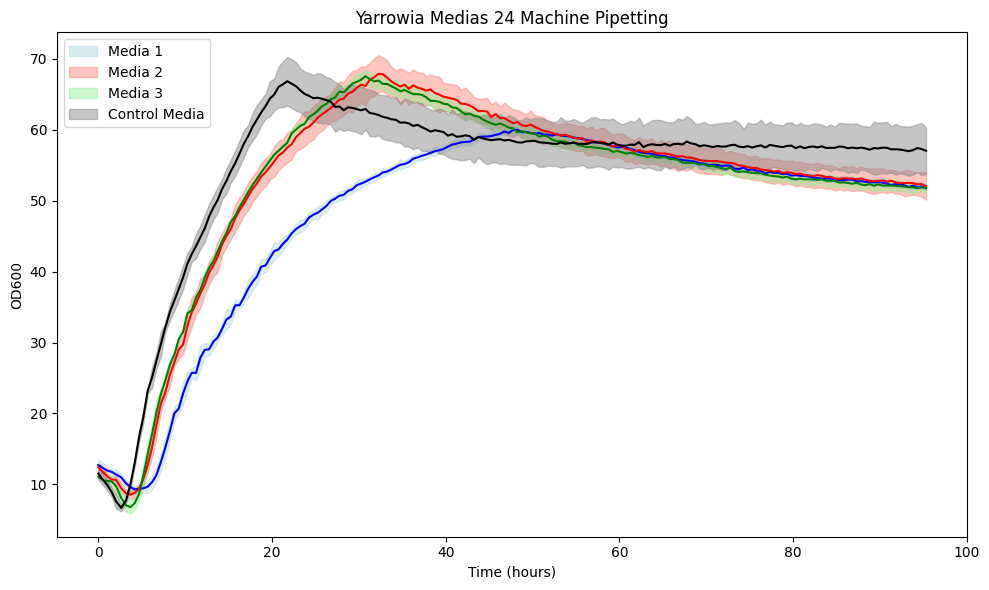

ANOVA results across entire time series:
F-statistic: 7.2485
p-value: 8.4710e-05
 Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1  group2 meandiff p-adj   lower   upper  reject
------------------------------------------------------
Media_1 Media_2   4.5368 0.0081  0.8731  8.2005   True
Media_1 Media_3   4.2217 0.0164   0.558  7.8853   True
Media_1 Media_4    6.418    0.0  2.7544 10.0817   True
Media_2 Media_3  -0.3152 0.9962 -3.9788  3.3485  False
Media_2 Media_4   1.8812 0.5491 -1.7824  5.5449  False
Media_3 Media_4   2.1964 0.4119 -1.4673  5.8601  False
------------------------------------------------------


In [59]:
df = pd.read_excel(pathxlsx, sheet_name='GreenVal96_Manual', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6', 'B4', 'B5', 'B6', 'C4', 'C5', 'C6']].mean(axis=1)
df['Media_3_Avg'] = df[['A7', 'A8', 'A9', 'B7', 'B8', 'B9', 'C7', 'C8', 'C9']].mean(axis=1)
df['Media_4_Avg'] = df[['A10', 'A11', 'A12', 'B10', 'B11', 'B12', 'C10', 'C11', 'C12']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3', 'B1', 'B2', 'B3', 'C1', 'C2', 'C3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6', 'B4', 'B5', 'B6', 'C4', 'C5', 'C6']].std(axis=1)
df['Media_3_Std'] = df[['A7', 'A8', 'A9', 'B7', 'B8', 'B9', 'C7', 'C8', 'C9']].std(axis=1)
df['Media_4_Std'] = df[['A10', 'A11', 'A12', 'B10', 'B11', 'B12', 'C10', 'C11', 'C12']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 96 Manual Pipetting')
ax.legend()

plt.tight_layout()
plt.show()


# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")


# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())
#==================================================================================#

df = pd.read_excel(pathxlsx, sheet_name='GreenVal96_Robot', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6']].mean(axis=1)
df['Media_3_Avg'] = df[['A7', 'A8', 'A9']].mean(axis=1)
df['Media_4_Avg'] = df[['A10', 'A11', 'A12']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6']].std(axis=1)
df['Media_3_Std'] = df[['A7', 'A8', 'A9']].std(axis=1)
df['Media_4_Std'] = df[['A10', 'A11', 'A12']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 96 Machine Pipetting')
ax.legend()

plt.tight_layout()
plt.show()

# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")


# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())
#==================================================================================#


df = pd.read_excel(pathxlsx, sheet_name='GreenVal24_Manual', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6']].mean(axis=1)
df['Media_3_Avg'] = df[['B1', 'B2', 'B3']].mean(axis=1)
df['Media_4_Avg'] = df[['B4', 'B5', 'B6']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6']].std(axis=1)
df['Media_3_Std'] = df[['B1', 'B2', 'B3']].std(axis=1)
df['Media_4_Std'] = df[['B4', 'B5', 'B6']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 24 Human Pipetting')
ax.legend()

plt.tight_layout()
plt.show()

# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")


# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())
#==================================================================================#


df = pd.read_excel(pathxlsx, sheet_name='GreenVal24_Robot', header = 0, index_col=0)

# Convert time from minutes to hours
df.index = df.index / 60

# define mean for each media at each time point
df['Media_1_Avg'] = df[['A1', 'A2', 'A3']].mean(axis=1)
df['Media_2_Avg'] = df[['A4', 'A5', 'A6']].mean(axis=1)
df['Media_3_Avg'] = df[['B1', 'B2', 'B3']].mean(axis=1)
df['Media_4_Avg'] = df[['B4', 'B5', 'B6']].mean(axis=1)

# define std for each media at each time point
df['Media_1_Std'] = df[['A1', 'A2', 'A3']].std(axis=1)
df['Media_2_Std'] = df[['A4', 'A5', 'A6']].std(axis=1)
df['Media_3_Std'] = df[['B1', 'B2', 'B3']].std(axis=1)
df['Media_4_Std'] = df[['B4', 'B5', 'B6']].std(axis=1)

# create plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.fill_between(df.index, df['Media_1_Avg'] - df['Media_1_Std'], df['Media_1_Avg'] + df['Media_1_Std'], alpha = 0.45, label='Media 1', color='lightblue')
ax.plot(df.index, df['Media_1_Avg'], color='blue')

ax.fill_between(df.index, df['Media_2_Avg'] - df['Media_2_Std'], df['Media_2_Avg'] + df['Media_2_Std'], alpha = 0.45, label='Media 2', color='salmon')
ax.plot(df.index, df['Media_2_Avg'], color='red')

ax.fill_between(df.index, df['Media_3_Avg'] - df['Media_3_Std'], df['Media_3_Avg'] + df['Media_3_Std'], alpha = 0.45, label='Media 3', color='lightgreen')
ax.plot(df.index, df['Media_3_Avg'], color='green')

ax.fill_between(df.index, df['Media_4_Avg'] - df['Media_4_Std'], df['Media_4_Avg'] + df['Media_4_Std'], alpha = 0.45, label='Control Media', color='grey')
ax.plot(df.index, df['Media_4_Avg'], color='black')


ax.set_xlabel('Time (hours)')
ax.set_ylabel('OD600')
ax.set_title('Yarrowia Medias 24 Machine Pipetting')
ax.legend()

plt.tight_layout()
plt.show()

# Perform one-way ANOVA across the entire time series
f_stat, p_val = f_oneway(df['Media_1_Avg'], df['Media_2_Avg'], df['Media_3_Avg'], df['Media_4_Avg'])

print(f"ANOVA results across entire time series:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_val:.4e}")


# Prepare data for Tukey's HSD
data = pd.DataFrame({
    'OD600': pd.concat([
        df['Media_1_Avg'],
        df['Media_2_Avg'],
        df['Media_3_Avg'],
        df['Media_4_Avg']
    ]),
    'Media': ['Media_1'] * len(df) + ['Media_2'] * len(df) + ['Media_3'] * len(df) + ['Media_4'] * len(df)
})

# Run Tukey's HSD test
tukey_result = pairwise_tukeyhsd(endog=data['OD600'], groups=data['Media'], alpha=0.05)
print(tukey_result.summary())
#==================================================================================#
